In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.4.1+cpu
torchvision version: 0.19.1+cpu


In [5]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [5]:


from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
import os
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=str(train_dir),
                                                                               test_dir=str(train_dir),
                                                                               transform=transform,
                                                                               batch_size=32,
                                                                               num_workers=os.cpu_count())

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2311b0396c0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [3]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights)

model # uncomment to output (it's very long)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", 'trainable'], # uncomment for smaller output
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    True
├─Sequential (features)                                      [32, 3, 224, 224]    True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   True
│    │    └─MBConv (0)                                       [32, 32, 112, 112]   True
│    └─Sequential (2)                                        [32, 16, 112, 112]   True
│    │    └─MBConv (0)                                       [32, 16, 112, 112]   True
│    │    └─MBConv (1)                  

In [7]:
for param in model.features.parameters():
    param.requires_grad = False

In [8]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [19]:
out_features = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=out_features)
)

In [20]:
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [22]:
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [23]:
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device='cpu')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1153 | train_acc: 0.3320 | test_loss: 0.8811 | test_acc: 0.8398
Epoch: 2 | train_loss: 0.9068 | train_acc: 0.6445 | test_loss: 0.7330 | test_acc: 0.8984
Epoch: 3 | train_loss: 0.8180 | train_acc: 0.7031 | test_loss: 0.6201 | test_acc: 0.9102
Epoch: 4 | train_loss: 0.6569 | train_acc: 0.8398 | test_loss: 0.5530 | test_acc: 0.9102
Epoch: 5 | train_loss: 0.6032 | train_acc: 0.8594 | test_loss: 0.5060 | test_acc: 0.9336


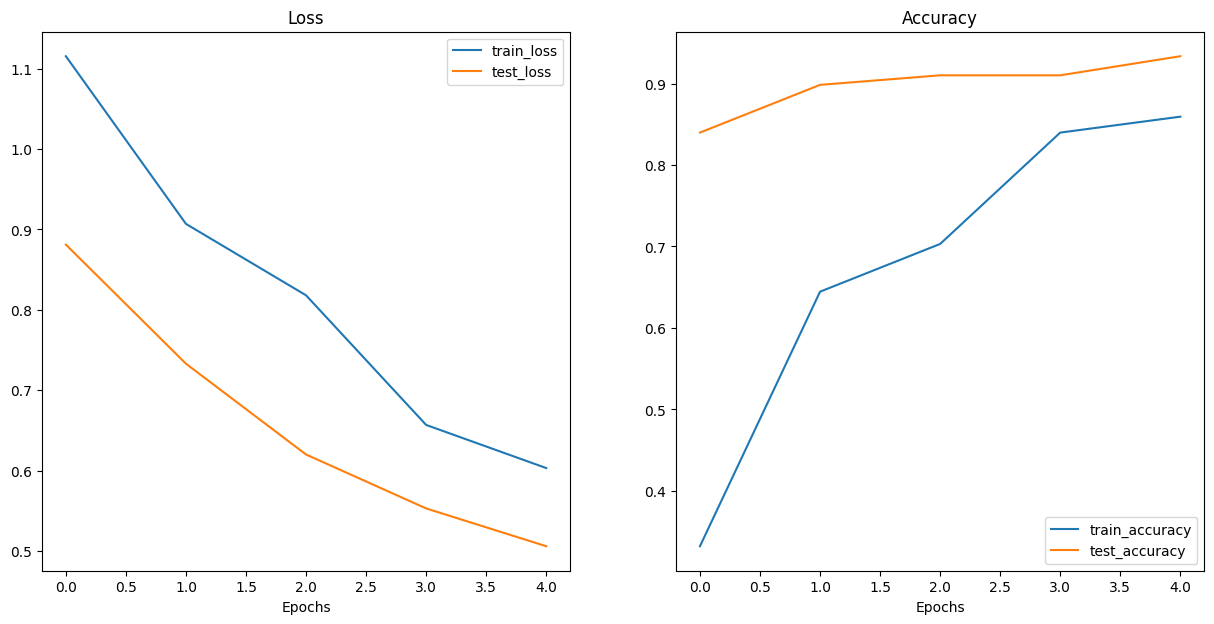

In [24]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [42]:
from typing import List, Tuple
import matplotlib.pyplot as plt

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,):
    
    img = Image.open(image_path)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    img_tensor = image_transform(img).unsqueeze(dim=0)

    model.eval()

    with torch.inference_mode():

        pred_logits = model(img_tensor)
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_name = class_names[pred_logits.argmax(dim=1)]

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {pred_name} | Prob: {pred_probs.max():.3f}")
    plt.axis(False)

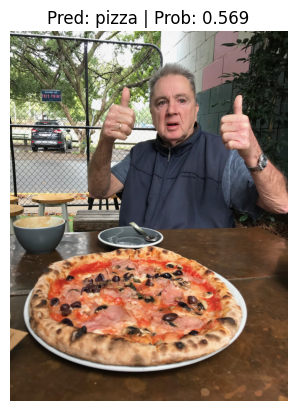

In [43]:
pred_and_plot_image(model=model,
                    image_path='data/04-pizza-dad.jpeg',
                    class_names=class_names,
                    image_size=(224, 224)
                    )

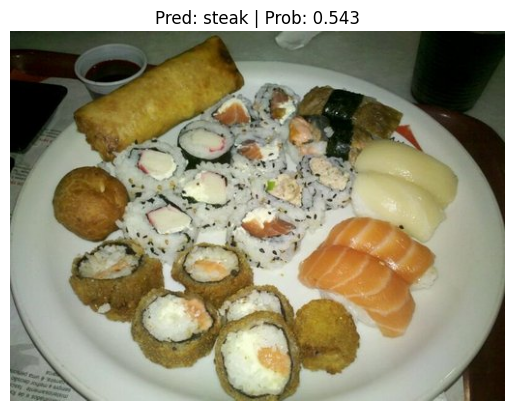

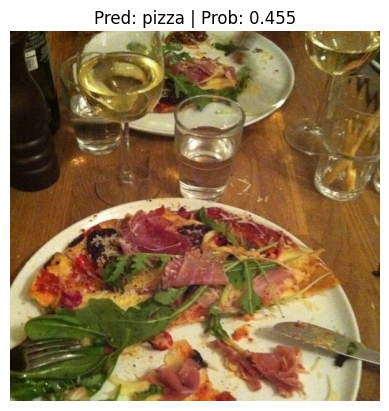

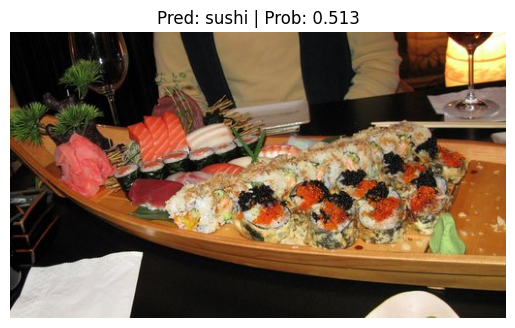

In [44]:
import random

num_images_to_show = 3
all_images = list(Path(test_dir).glob('*/*.jpg'))
images_to_show = random.sample(population=all_images,
                               k = num_images_to_show)

for image_path in images_to_show:
    pred_and_plot_image(model=model,
                        image_path=str(image_path),
                        class_names=class_names,
                        image_size=(224, 224))

In [40]:
images_to_show

[WindowsPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/930553.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/steak/100274.jpg')]